# Machine Learning for Drug Discovery

### Introduction

The time taken for a drug to jump past all the hurdles from initial discovery to being marketed can be roughly a decade and the cost associated with research and subsequent clinical trials is in the order of a billion US dollars.[¹](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3058157/) This is not the end of the list of challenges as only 12% of of drugs make it to market.[²](https://www.cbo.gov/publication/57126). The aim of this project is to train a model that can **predict IC50 values**, which is a measure of drug potency based on **PubChem fingerprints**. PubChem fingerprints are a series of binary digits used to represent the chemical structure. For example, the first bit position indicates whether the compound has at least 4 hydrogen atoms.[³](https://web.cse.ohio-state.edu/~zhang.10631/bak/drugreposition/list_fingerprints.pdf) With a well trained model, we can then look at the **important features for IC50 prediction** to understand which structural features drive potency to aid optimisation of the chemical structure. This model would also be helpful for predicting IC50 values of libraries of compounds against the target protein, aromotase, which can be useful to narrow down compounds to test in the lab.

This project is inspired by a bioinformatics project done by Chanin Nantasenamat.[⁴](https://github.com/dataprofessor/code/tree/master/python)

### Data collection and pre-processing

In [3]:
pip install chembl_webresource_client

  Using cached chembl_webresource_client-0.10.8-py3-none-any.whl (55 kB)
     ---------------------------------------- 62.8/62.8 kB 3.5 MB/s eta 0:00:00
  Using cached requests_cache-0.7.5-py3-none-any.whl (39 kB)
     -------------------------------------- 140.4/140.4 kB 8.1 MB/s eta 0:00:00
  Using cached easydict-1.10.tar.gz (6.4 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 61.5/61.5 kB ? eta 0:00:00
     ---------------------------------------- 153.2/153.2 kB ? eta 0:00:00
  Using cached url_normalize-1.4.3-py2.py3-none-any.whl (6.8 kB)
  Created wheel for easydict: filename=easydict-1.10-py3-none-any.whl size=6492 sha256=3b2bbb87a0bef69d3fe09ae0de88664d5b275d838b6476f2059783be2c74a124
  Stored in directory: c:\users\chuaw\appdata\local\pip\cache\wheels\8d\d6\16\3fd964549d5c27d89d6c5fdb4306283ca55be1799f3d48a67b
Successfully built easydict
Note: you may need to restart the ker

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors,Lipinski,rdchem

In [2]:
#searching and selecting human aromatase enzyme as the drug target
target_query = new_client.target.search("aromatase")
targets = pd.DataFrame(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P11511', 'xref_name': None, 'xre...",Homo sapiens,Cytochrome P450 19A1,20.0,False,CHEMBL1978,"[{'accession': 'P11511', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'P22443', 'xref_name': None, 'xre...",Rattus norvegicus,Cytochrome P450 19A1,20.0,False,CHEMBL3859,"[{'accession': 'P22443', 'component_descriptio...",SINGLE PROTEIN,10116


In [3]:
selected_target = targets.target_chembl_id[0]

In [23]:
#selecting compounds that can bind to the target protein with standard type as IC50
activity = new_client.activity
bio_activity = activity.filter(target_chembl_id = selected_target).filter(standard_type = "IC50")
df = pd.DataFrame(bio_activity)

#removing instances with missing standard values(roughly 3% of the entire dataset) and instances where standard unit is not nM (roughly 1% of the entire dataset)
df2 = df.copy()
df2.standard_value = df2.standard_value.astype(float)
df2 = df2[df2.standard_value.notna()]
df2 = df2[df2.standard_units=='nM']
df2.to_csv("compound_data.csv", index=False)

#selecting features that relate to the chemical structure(canonical smiles) and compound biological activity(standard value)
df3 = df2.copy()
sel = ['canonical_smiles', 'molecule_chembl_id', 'standard_value']
df3 = df3[sel]
df3.head()

,canonical_smiles,molecule_chembl_id,standard_value
0,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,CHEMBL341591,7100.0
1,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,CHEMBL2111947,50000.0
2,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,CHEMBL431859,238.0
3,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,CHEMBL113637,57.0
4,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,CHEMBL112021,54.0


In [5]:
df3.to_csv("preprocessed_compound_data.csv", index=False)

### Data processing

In [6]:
#function to cap the standard values between 1*10^8 nM and 1*10^-12 nM so that log10 function does not encounter zero and ligand efficiency is not 0.
def norm_value(input):
    norm = []
    for i in df3["standard_value"]:
        if i >100000000:
            i = 100000000
        elif i == 0:
            i=0.000000000001
        norm.append(i)
    
    df3["standard_value_norm"] = norm
    x = df3.drop("standard_value", axis=1)
    return x

In [7]:
df3 = norm_value(df3)

In [8]:
def LEcalc(smiles,standard_value,verbose=False):
    
    molecules = []
    HAC = []
    le = []
    
    for i in smiles:
        mol = Chem.MolFromSmiles(i)
        molecules.append(mol)
    for j in molecules:
        HAC.append(j.GetNumHeavyAtoms())
    for k in range(len(HAC)):
        IC50 = (float(standard_value[k]))*10**(-9)
        le.append((-1.4*np.log10(IC50))/HAC[k])
    return le

In [10]:
#computing ligand efficiency values using LEcalc function     
df3['le'] = LEcalc(df3.canonical_smiles,df3.standard_value_norm.tolist())
df3.head()

,canonical_smiles,molecule_chembl_id,standard_value_norm,le
0,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,CHEMBL341591,7100.0,0.300343
1,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,CHEMBL2111947,50000.0,0.261802
2,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,CHEMBL431859,238.0,0.356646
3,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,CHEMBL113637,57.0,0.422574
4,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,CHEMBL112021,54.0,0.442376


The ligand efficiency cut off for hit compounds is set to be between 0.2 and 0.35. Hit compounds are compounds that show some activity against the target protein and can be chemically modified to have improved potency and drug-like properties. The binding of hits to the target does not have to be extremely good as this can be optimised further after hit identification. This broad range of ligand efficiencies chosen is due a large range of heavy atom counts (HAC) among all the screened compounds. HAC is a proxy for molecular size. The optimal ligand effiency cut off depends on the molecular size of the screened compounds. The details of calculating target ligand efficiency values can be found in this paper. [⁵](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3772997/#FD2). A larger range of ligand efficiency values also allow for a more diverse set of hits to be investigated. This can potentially lead to drug molecules with novel structures compared to marketed drugs.

In [11]:
bioactivity_class = []

for i in df3['le']:
    if i>0.2 and i<0.35:
        bioactivity_class.append("active")
    else:
        bioactivity_class.append("inactive")
df3['bioactivity_class'] = bioactivity_class

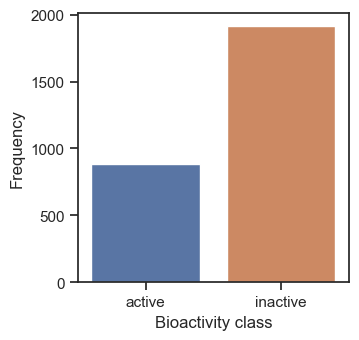

In [12]:
bio_class = []
classes = ['active', 'inactive']
for i in classes:
    frequency = bioactivity_class.count(i)
    bio_class.append(frequency)
plt.figure(figsize=(3.5,3.5))
ax = sns.barplot(x=classes,y=bio_class)
ax.set(xlabel='Bioactivity class',
       ylabel='Frequency')
plt.show()

In [13]:
#Calculating Lipinksi Rule of 5 descriptors
def descriptors(smiles,verbose=False):
    
    molecules = []
    for i in smiles:
        mol = Chem.MolFromSmiles(i)
        molecules.append(mol)
    
    i=0
    for j in molecules:
        
        desc_MolWt = Descriptors.MolWt(j)
        desc_LogP = Descriptors.MolLogP(j)
        desc_NumHDonors = Lipinski.NumHDonors(j)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(j)
        
        row = np.array([desc_MolWt, desc_LogP, desc_NumHDonors, desc_NumHAcceptors])   
        
        if i==0:
            baseData = row
            
        else:
            baseData = np.vstack([baseData, row])
        i=i+1
    
    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data = baseData, columns = columnNames)
   
    return descriptors

In [14]:
index=np.arange(0,2806,1)
df_lipinski = descriptors(df3.canonical_smiles)
df_lipinski['index']=index
df3['index']=index

In [15]:
df_combined = df3.merge(df_lipinski)
df_combined.head()

,canonical_smiles,molecule_chembl_id,standard_value_norm,le,bioactivity_class,index,MW,LogP,NumHDonors,NumHAcceptors
0,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,CHEMBL341591,7100.0,0.300343,active,0,329.528,4.28820,2.0,2.0
1,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,CHEMBL2111947,50000.0,0.261802,active,1,315.501,3.89810,2.0,2.0
2,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,CHEMBL431859,238.0,0.356646,inactive,2,412.306,5.70542,0.0,3.0
3,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,CHEMBL113637,57.0,0.422574,inactive,3,319.383,4.63450,0.0,3.0
4,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,CHEMBL112021,54.0,0.442376,inactive,4,321.811,4.58780,0.0,3.0


In [16]:
df_combined.to_csv('compounds_descriptors.csv')

Convert IC50 values to pIC50 values to allow easier understanding of standard value distributions.

In [17]:
def pIC50(data):
    pIC50 = []
    for i in data["standard_value_norm"]:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))
    data["pIC50"] = pIC50
    final = data.drop("standard_value_norm", axis=1) 
    return final

In [18]:
df_pIC50 = pIC50(df_combined)
df_pIC50.head()

,canonical_smiles,molecule_chembl_id,le,bioactivity_class,index,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,CHEMBL341591,0.300343,active,0,329.528,4.28820,2.0,2.0,5.148742
1,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,CHEMBL2111947,0.261802,active,1,315.501,3.89810,2.0,2.0,4.301030
2,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,CHEMBL431859,0.356646,inactive,2,412.306,5.70542,0.0,3.0,6.623423
3,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,CHEMBL113637,0.422574,inactive,3,319.383,4.63450,0.0,3.0,7.244125
4,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,CHEMBL112021,0.442376,inactive,4,321.811,4.58780,0.0,3.0,7.267606


### Exploratory Data Analysis

In [19]:
#Mann–Whitney U test to determine whether the difference in a feature is significant for active and inactive compounds. 
def mannwhitney(descriptor, verbose=False):
    from scipy.stats import mannwhitneyu
    
    selection = [descriptor, "bioactivity_class"]
    df = df_pIC50[selection]
    active = df[df.bioactivity_class == "active"]
    active = active[descriptor]
    
    inactive = df[df.bioactivity_class == "inactive"]
    inactive = inactive[descriptor]
    
    stat, p = mannwhitneyu(active,inactive)
    
    alpha = 0.05
    if p > 0.05:
        interpretation = "The difference between active and inactive compounds is statistically insignificant."
    if p < 0.05:
        interpretation = "The difference between active and inactive compounds is statistically significant. "
        
    return interpretation,"p value is "+ str(p)
    

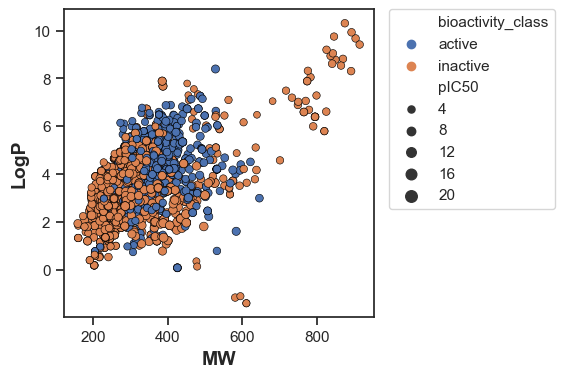

In [22]:
plt.figure(figsize=(4,4))
sns.scatterplot(x="MW", y="LogP", data=df_pIC50, hue = 'bioactivity_class',size='pIC50', edgecolor='black')
plt.xlabel("MW",fontsize=14, fontweight='bold')
plt.ylabel("LogP",fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)
plt.savefig("Plots/MW_against_logP_plot.png",bbox_inches='tight')

Most of the compounds have a molecular weight of between 200 and 500 Da and logP values between 1 and 6. This is reasonable as drugs with MW>500 and logP>5 tend to lead to poor absorption.[⁶](https://www.sciencedirect.com/science/article/pii/S0169409X96004231) Good absorption is needed for orally administered drugs. 

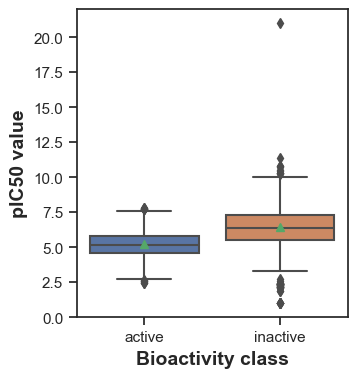

In [25]:
plt.figure(figsize=(3.5,4))
sns.boxplot(x="bioactivity_class", y="pIC50", data=df_pIC50,showmeans=True)
plt.xlabel("Bioactivity class",fontsize=14, fontweight="bold")
plt.ylabel("pIC50 value",fontsize=14, fontweight="bold")
plt.savefig("Plots/pIC50_plot.png")

As expected, the pIC50 values for active compounds are lower than for inactive compounds.

In [26]:
mannwhitney("pIC50")

('The difference between active and inactive compounds is statistically significant. ',
 'p value is 5.059831920548439e-127')

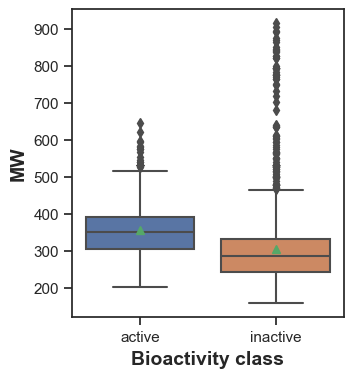

In [27]:
plt.figure(figsize=(3.5,4))
sns.boxplot(x="bioactivity_class",y="MW", data=df_pIC50,showmeans=True)

plt.xlabel("Bioactivity class",fontsize=14, fontweight="bold")
plt.ylabel("MW",fontsize=14, fontweight="bold")
plt.savefig("Plots/class_against_MW_plot.png")

In [24]:
mannwhitney("MW")

('The difference between active and inactive compounds is statistically significant. ',
 'p value is 4.9351373174942564e-86')

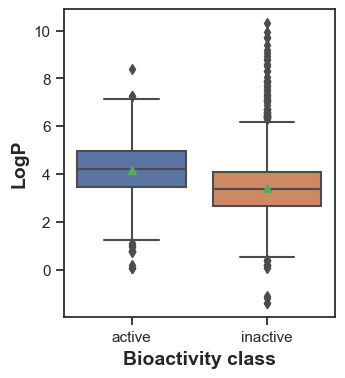

In [28]:
plt.figure(figsize=(3.5,4))
sns.boxplot(x="bioactivity_class",y="LogP", data=df_pIC50,showmeans=True)

plt.xlabel("Bioactivity class",fontsize=14, fontweight="bold")
plt.ylabel("LogP",fontsize=14, fontweight="bold")
plt.savefig("Plots/class_against_logP_plot.png")

In [26]:
mannwhitney("LogP")

('The difference between active and inactive compounds is statistically significant. ',
 'p value is 2.486260332683729e-59')

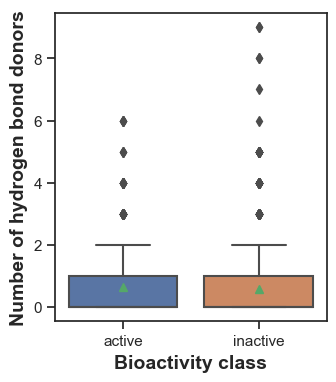

In [29]:
plt.figure(figsize=(3.5,4))
sns.boxplot(x="bioactivity_class",y="NumHDonors", data=df_pIC50,showmeans=True)
plt.xlabel("Bioactivity class",fontsize=14, fontweight="bold")
plt.ylabel("Number of hydrogen bond donors",fontsize=14, fontweight="bold")
plt.savefig("Plots/class_against_NumHDonors_plot.png")

In [28]:
mannwhitney("NumHDonors")

('The difference between active and inactive compounds is statistically insignificant.',
 'p value is 0.2026376755980096')

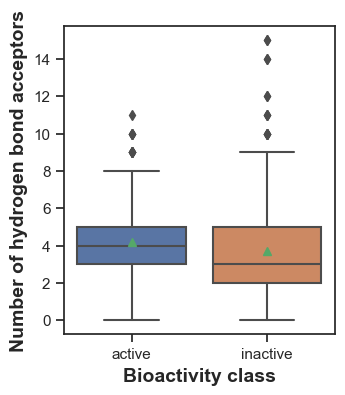

In [30]:
plt.figure(figsize=(3.5,4))
sns.boxplot(x="bioactivity_class",y="NumHAcceptors", data=df_pIC50,showmeans=True)
plt.xlabel("Bioactivity class",fontsize=14, fontweight="bold")
plt.ylabel("Number of hydrogen bond acceptors",fontsize=14, fontweight="bold")
plt.savefig("Plots/class_against_NumHAcceptors_plot.png")

In [30]:
mannwhitney("NumHAcceptors")

('The difference between active and inactive compounds is statistically significant. ',
 'p value is 1.2959599018241656e-14')

#### Interpretation of results

Active compounds have higher MWs, higher logP values and higher numbers of hydrogen bond acceptors. The difference in number of hydrogen bond donors for active and inactive compounds is not significant. There may be some hydrogen bonding happening between active compounds and the target binding site. However,this cannot be confirmed without further studies. High MW and high logP tend to result in poor absorption as mentioned above and these metrics can result in undersirable non-specific binding interactions. However, majority of the active compounds have MW<500 and logP<5, so the binding should be specific enough to the target protein.

### Data preparation

In [31]:
selection = ['canonical_smiles', 'molecule_chembl_id']
df_prep = df_pIC50[selection]
df_prep.to_csv("molecule.smi",sep="\t",index=False, header=False)

In [32]:
!type molecule.smi

CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12	CHEMBL341591
C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43C)[C@@H]1CC[C@@H]2[C@H]1CN1	CHEMBL2111947
CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21	CHEMBL431859
CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21	CHEMBL113637
Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21	CHEMBL112021
Cc1ccc(S(=O)(=O)n2cc(C(c3ccccc3)n3ccnc3)c3ccccc32)cc1	CHEMBL324070
CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21	CHEMBL41761
Cn1cc(C(c2ccc(F)cc2)n2ccnc2)c2cc(Br)ccc21	CHEMBL111868
CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2cc(Br)ccc21	CHEMBL111888
CCn1ccc2cc(C(c3ccccc3)n3ccnc3)ccc21	CHEMBL112074
N#Cc1ccc(Cn2cc(Cn3ccnc3)c3ccccc32)cc1	CHEMBL324326
CCCCCCN1C(=O)CCC(CC)(c2ccncc2)C1=O	CHEMBL37321
c1ccc2c(c1)CCC1C(c3cc[nH]n3)C21	CHEMBL353068
CCCCCCCC1(c2ccncc2)CCC(=O)NC1=O	CHEMBL41066
O=C1/C(=C/c2cccnn2)CCc2ccccc21	CHEMBL166709
O=C1/C(=C/c2ccnnc2)CCc2ccccc21	CHEMBL424556
C[C@]12CC[C@H]3[C@@H](CC=C4[C@H](O)CCC[C@@]43CO)[C@@H]1CCC2=O	CHEMBL1630273
C[C@]12CC[C@H]3[C@@H](C[C@@H](O)C4=CCCC[C@@]43C)[C@@H]1CCC2=O	CHEMBL1

In [33]:
#using file from https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
import urllib.request
url = 'https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh'
filename = 'padel.sh'
urllib.request.urlretrieve(url, filename)

('padel.sh', <http.client.HTTPMessage at 0x15d57ccc648>)

In [34]:
!bash padel.sh

Processing CHEMBL341591 in molecule.smi (1/2806). 
Processing CHEMBL2111947 in molecule.smi (2/2806). 
Processing CHEMBL431859 in molecule.smi (3/2806). 
Processing CHEMBL112021 in molecule.smi (5/2806). 
Processing CHEMBL113637 in molecule.smi (4/2806). 
Processing CHEMBL324070 in molecule.smi (6/2806). 
Processing CHEMBL41761 in molecule.smi (7/2806). 
Processing CHEMBL111868 in molecule.smi (8/2806). 
Processing CHEMBL111888 in molecule.smi (9/2806). 
Processing CHEMBL112074 in molecule.smi (10/2806). 
Processing CHEMBL324326 in molecule.smi (11/2806). 
Processing CHEMBL37321 in molecule.smi (12/2806). 
Processing CHEMBL353068 in molecule.smi (13/2806). 
Processing CHEMBL41066 in molecule.smi (14/2806). 
Processing CHEMBL166709 in molecule.smi (15/2806). 
Processing CHEMBL424556 in molecule.smi (16/2806). 
Processing CHEMBL1630273 in molecule.smi (17/2806). Average speed: 2.12 s/mol.
Processing CHEMBL1630261 in molecule.smi (18/2806). Average speed: 2.17 s/mol.
Processing CHEMBL1692

In [32]:
df_prep= pd.read_csv("descriptors_output.csv")
df_prep_X = df_prep.copy()
df_prep_X = df_prep_X.drop(columns=["Name"])
df_prep_y = df_pIC50["pIC50"]

In [34]:
dataset = pd.concat([df_prep_X,df_prep_y],axis=1)
dataset.to_csv("train_and_test.csv",index=False)

### Model Building and Evaluation

In [35]:
#importing libraries
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf

In [36]:
def metrics(X_train,X_test,y_train,y_test,model):
    y_pred = model.predict(X_test)
    print("Training set accuracy:{:0.2f} ".format(model.score(X_train,y_train)))
    print("Test set accuracy:{:0.2f} ".format(model.score(X_test,y_test)))
    print("Mean square error:{:0.2f} ".format(mean_squared_error(y_test,y_pred)))
    print("Mean absolute error:{:0.2f} ".format(mean_absolute_error(y_test,y_pred)))
    print("Root Mean square error:{:0.2f} ".format((mean_squared_error(y_test,y_pred))**0.5))
    print("-------------------------------------")
    return

In [37]:
df = pd.read_csv("train_and_test.csv")
X = df.drop("pIC50",axis=1)
y = df.pIC50

#Removing low variance features
selection = VarianceThreshold(threshold = 0.8 * (1 - 0.8))
X = selection.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [189]:
#unoptimised models
ran_for = RandomForestRegressor(n_estimators=100, max_depth=3)
ran_for.fit(X_train_scaled, y_train)
metrics(X_train_scaled,X_test_scaled,y_train,y_test,ran_for)

#optimised model
ran_for = RandomForestRegressor(n_estimators=100, max_depth=5,max_features='sqrt')
ran_for.fit(X_train_scaled, y_train)
metrics(X_train_scaled,X_test_scaled,y_train,y_test,ran_for)

Training set accuracy:0.23 
Test set accuracy:0.21 
Mean square error:1.44 
Mean absolute error:0.93 
Root Mean square error:1.20 
-------------------------------------
Training set accuracy:0.28 
Test set accuracy:0.26 
Mean square error:1.35 
Mean absolute error:0.89 
Root Mean square error:1.16 
-------------------------------------


In [52]:
grid = {
    'max_depth': [5, 20, 60, 90],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [100, 300, 500]
}
rf_grid = GridSearchCV(estimator=ran_for,param_grid=grid,cv=3,scoring='neg_mean_squared_error').fit(X_train,y_train)

In [58]:
ran_for_grid = pd.DataFrame(rf_grid.cv_results_)
ran_for_grid.to_csv('grid_ran_for.csv')

In [182]:
svr = SVR(kernel='poly').fit(X_train_scaled, y_train)
metrics(X_train_scaled,X_test_scaled,y_train,y_test,svr)

svr = SVR(kernel='poly',C=1, gamma=0.01).fit(X_train_scaled, y_train)
metrics(X_train_scaled,X_test_scaled,y_train,y_test,svr)

Training set accuracy:0.37 
Test set accuracy:0.28 
Mean square error:1.32 
Mean absolute error:0.86 
Root Mean square error:1.15 
-------------------------------------
Training set accuracy:0.44 
Test set accuracy:0.26 
Mean square error:1.36 
Mean absolute error:0.87 
Root Mean square error:1.16 
-------------------------------------


In [74]:
C_range = 10. ** np.arange(-3, 8)
gamma_range = 10. ** np.arange(-5, 4)
grid_2 = dict(gamma=gamma_range, C=C_range)
svr_grid = GridSearchCV(estimator=svr,param_grid=grid_2,cv=3).fit(X_train_scaled,y_train)

In [75]:
svr_grid = pd.DataFrame(svm_grid.cv_results_)
svr_grid.to_csv('grid_svm.csv')

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

model = Sequential([
    Dense(600, activation='relu'),
    Dense(600, activation='relu'),
    Dense(600, activation='relu'),
    Dense(1, activation='linear'),
])
opt = Adam(learning_rate=0.0005)
mse = MeanSquaredError()
model.compile(optimizer=opt,loss=mse, metrics='accuracy')
model.fit(X_train_scaled,y_train,epochs=200,validation_split=0.1)

Epoch 1/200
60/60 [==============================] - 2s 19ms/step - loss: 3.1868 - accuracy: 0.0032 - val_loss: 1.3996 - val_accuracy: 0.0000e+00
Epoch 2/200
60/60 [==============================] - 1s 12ms/step - loss: 1.7097 - accuracy: 0.0032 - val_loss: 1.5381 - val_accuracy: 0.0000e+00
Epoch 3/200
60/60 [==============================] - 1s 12ms/step - loss: 1.5880 - accuracy: 0.0032 - val_loss: 1.3576 - val_accuracy: 0.0000e+00
Epoch 4/200
60/60 [==============================] - 1s 11ms/step - loss: 1.5537 - accuracy: 0.0032 - val_loss: 1.4297 - val_accuracy: 0.0000e+00
Epoch 5/200
60/60 [==============================] - 1s 12ms/step - loss: 1.5856 - accuracy: 0.0032 - val_loss: 1.4533 - val_accuracy: 0.0000e+00
Epoch 6/200
60/60 [==============================] - 1s 12ms/step - loss: 1.5605 - accuracy: 0.0032 - val_loss: 1.4431 - val_accuracy: 0.0000e+00
Epoch 7/200
60/60 [==============================] - 1s 11ms/step - loss: 1.4565 - accuracy: 0.0032 - val_loss: 1.5868 - val

Epoch 57/200
60/60 [==============================] - 1s 11ms/step - loss: 1.0490 - accuracy: 0.0032 - val_loss: 1.8523 - val_accuracy: 0.0000e+00
Epoch 58/200
60/60 [==============================] - 1s 10ms/step - loss: 1.0727 - accuracy: 0.0032 - val_loss: 1.8953 - val_accuracy: 0.0000e+00
Epoch 59/200
60/60 [==============================] - 1s 10ms/step - loss: 1.0511 - accuracy: 0.0032 - val_loss: 1.5792 - val_accuracy: 0.0000e+00
Epoch 60/200
60/60 [==============================] - 1s 10ms/step - loss: 1.0829 - accuracy: 0.0032 - val_loss: 1.7537 - val_accuracy: 0.0000e+00
Epoch 61/200
60/60 [==============================] - 1s 10ms/step - loss: 1.0395 - accuracy: 0.0032 - val_loss: 1.6936 - val_accuracy: 0.0000e+00
Epoch 62/200
60/60 [==============================] - 1s 10ms/step - loss: 1.0358 - accuracy: 0.0032 - val_loss: 1.7989 - val_accuracy: 0.0000e+00
Epoch 63/200
60/60 [==============================] - 1s 11ms/step - loss: 1.0619 - accuracy: 0.0032 - val_loss: 1.919

60/60 [==============================] - 1s 11ms/step - loss: 0.9204 - accuracy: 0.0032 - val_loss: 1.6365 - val_accuracy: 0.0000e+00
Epoch 113/200
60/60 [==============================] - 1s 11ms/step - loss: 0.9182 - accuracy: 0.0032 - val_loss: 1.6357 - val_accuracy: 0.0000e+00
Epoch 114/200
60/60 [==============================] - 1s 10ms/step - loss: 0.9937 - accuracy: 0.0032 - val_loss: 1.5587 - val_accuracy: 0.0000e+00
Epoch 115/200
60/60 [==============================] - 1s 10ms/step - loss: 0.9001 - accuracy: 0.0032 - val_loss: 1.6140 - val_accuracy: 0.0000e+00
Epoch 116/200
60/60 [==============================] - 1s 10ms/step - loss: 0.9301 - accuracy: 0.0032 - val_loss: 1.5617 - val_accuracy: 0.0000e+00
Epoch 117/200
60/60 [==============================] - 1s 11ms/step - loss: 0.8612 - accuracy: 0.0032 - val_loss: 1.5795 - val_accuracy: 0.0000e+00
Epoch 118/200
60/60 [==============================] - 1s 11ms/step - loss: 0.9124 - accuracy: 0.0032 - val_loss: 1.6102 - val

60/60 [==============================] - 1s 10ms/step - loss: 0.8630 - accuracy: 0.0032 - val_loss: 1.6856 - val_accuracy: 0.0000e+00
Epoch 168/200
60/60 [==============================] - 1s 10ms/step - loss: 0.8727 - accuracy: 0.0032 - val_loss: 1.5805 - val_accuracy: 0.0000e+00
Epoch 169/200
60/60 [==============================] - 1s 10ms/step - loss: 0.8858 - accuracy: 0.0032 - val_loss: 1.5655 - val_accuracy: 0.0000e+00
Epoch 170/200
60/60 [==============================] - 1s 10ms/step - loss: 0.8879 - accuracy: 0.0032 - val_loss: 1.6299 - val_accuracy: 0.0000e+00
Epoch 171/200
60/60 [==============================] - 1s 11ms/step - loss: 0.8780 - accuracy: 0.0032 - val_loss: 1.6195 - val_accuracy: 0.0000e+00
Epoch 172/200
60/60 [==============================] - 1s 11ms/step - loss: 0.8562 - accuracy: 0.0032 - val_loss: 1.5675 - val_accuracy: 0.0000e+00
Epoch 173/200
60/60 [==============================] - 1s 10ms/step - loss: 0.8318 - accuracy: 0.0032 - val_loss: 1.5398 - val

In [39]:
y_pred = model.predict(X_test_scaled)

22/22 [==============================] - 0s 4ms/step


In [42]:
print('mean squared error: {}'.format(mean_squared_error(y_pred,y_test)))
print('accuracy test set: {}'.format(model.evaluate(X_test_scaled,y_test)[1]))

mean squared error: 2.2688609064137437
22/22 [==============================] - 0s 5ms/step - loss: 2.2689 - accuracy: 0.0014
accuracy test set: 0.0014245014172047377


In [43]:
outliers=[]
for i in range(len(y_pred)):
    if y_pred[i]>9 or y_pred[i]<3.3:
        outliers.append(i)

In [45]:
y_test_no_outliers = y_test.drop(y_test.index[outliers])
y_pred_no_outliers = np.delete(y_pred, (outliers), axis=0)

C:\ProgramData\Anaconda3\envs\test\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


r2 score: 0.12989646064635962


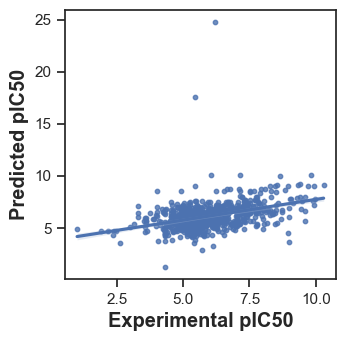

In [46]:
plt.figure(figsize=(3.5,3.5))
sns.regplot(y_test,y_pred,scatter_kws={"s": 10})
plt.xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
plt.ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
print('r2 score: {}'.format(r2_score(y_test_no_outliers,y_pred_no_outliers)))
# plt.plot(np.array([0,10]),np.array([3.3,3.3]))
# plt.plot(np.array([0,10]),np.array([9.5,9.5]))
plt.savefig("Plots/pIC50(predicted&experimental)regplot.png")
plt.show()

C:\ProgramData\Anaconda3\envs\test\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


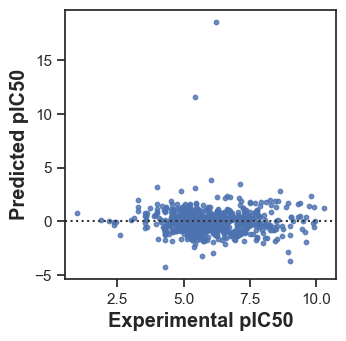

In [47]:
plt.figure(figsize=(3.5,3.5))
sns.residplot(y_test,y_pred,scatter_kws={"s": 10})
plt.xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
plt.ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
plt.savefig("Plots/pIC50(predicted&experimental)residplot.png")
plt.show()

### Conclusion

The r2 score without outliers is 0.13, which does not imply a strong correlation. This is expected as PubChem fingerprints is a less accurate molecular representation of the compounds compared to newer techniques.[⁷](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0195-1) However, visually, the points are clustered around the linear regression line and there are a reasonable amount of outliers, so the model did fit the data to a reasonable extent. This script can be improved by using a more accurate molecular fingerprint and potentially using other models that can fit the data better.